In [ ]:
import timeit
from pathlib import Path
import re
import sys
sys.path.append(str(Path.cwd().parent / "indelsim"))
sys.path.append(str(Path.cwd().parent))

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

from sim_config import SimConfiguration
from simulation import Simulation
from msa import Msa


TREES_PATH = Path.cwd() / "TRUE_TREES"


In [27]:
def scale_tree(tree_path: str, scale_factor: float, overwrite: bool=False):
    # Read the tree
    tree_path = Path(tree_path)

    with open(tree_path, 'r') as f:
        newick_str = f.read().strip()
    
    # Function to scale branch lengths in Newick string
    def scale_length(match):
        length = float(match.group(1))
        scaled = length * scale_factor
        return f":{scaled:.10f}"
    
    # Scale all branch lengths using regex
    scaled_newick = re.sub(r':([0-9.]+)', scale_length, newick_str)

    scaled_tree_path = (tree_path.parent / f"scaled_{scale_factor}.tree") if not overwrite else tree_path
    # Write the scaled tree directly
    with open(scaled_tree_path, 'w') as f:
        f.write(scaled_newick)
    return scaled_tree_path

# for tree_path in list(TREES_PATH.iterdir()):#[0.5, 1,2,4,8,16]:
#     scale_tree(str(tree_path), 10, True)


In [4]:
def refresh_sim(tree_file):
    ROOT_SEQUENCE_LENGTH = 50

    sim_config = SimConfiguration(original_sequence_length=ROOT_SEQUENCE_LENGTH, indel_length_alpha=2.0,
                                indel_truncated_length=50,
                                rate_ins=0.03, rate_del=0.09,
                                deletion_extra_edge_length=50,
                                switch_factor=200,
                                seed=111)
    sim = Simulation(input_tree=str(tree_file), config=sim_config)
    return sim
time_labels = ["tree", "hybrid", "blocktree", "blocklist", "naive"]


In [37]:

time_winners = []
measured_times: list[list[float]] = []





for tree_path in list(TREES_PATH.iterdir()):#[0.5, 1,2,4,8,16]:
    sim = refresh_sim(tree_path)
    hybrid_time = 1000#timeit.timeit(sim.msa_from_hybrid, number=5)
    blocklist_time = timeit.timeit(sim.msa_from_blocklist, number=1)
    blocktree_time = timeit.timeit(sim.msa_from_blocktree, number=1)
    naive_time = timeit.timeit(sim.msa_from_naive, number=1)

    time_measures = [tree_path, hybrid_time, blocktree_time, blocklist_time, naive_time]
    print(time_measures)
    measured_times.append(time_measures)



[PosixPath('/home/pupkolab/Dev/evo-sim/benchmark/TRUE_TREES/ELAVL2_true_tree.txt'), 1000, 0.0024178620001293893, 0.002270836999969106, 0.0018958469997869543]
[PosixPath('/home/pupkolab/Dev/evo-sim/benchmark/TRUE_TREES/CHMP4C_true_tree.txt'), 1000, 0.006004251000149452, 0.004531883000026937, 0.00433821399997214]
[PosixPath('/home/pupkolab/Dev/evo-sim/benchmark/TRUE_TREES/LCP1_true_tree.txt'), 1000, 0.0071224099999653845, 0.006572578000032081, 0.0040785520000099496]
[PosixPath('/home/pupkolab/Dev/evo-sim/benchmark/TRUE_TREES/OGFOD1_true_tree.txt'), 1000, 0.006553380000013931, 0.0064594420000503305, 0.0016877420000582788]
[PosixPath('/home/pupkolab/Dev/evo-sim/benchmark/TRUE_TREES/BRPF1_true_tree.txt'), 1000, 0.0066905419998875, 0.0024667699999554316, 0.0017689169999357546]
[PosixPath('/home/pupkolab/Dev/evo-sim/benchmark/TRUE_TREES/MTMR2_true_tree.txt'), 1000, 0.0022736390001227846, 0.0022660130000531353, 0.0015449580000677088]
[PosixPath('/home/pupkolab/Dev/evo-sim/benchmark/TRUE_TREES/

In [15]:
%%timeit
for tree_path in list(TREES_PATH.iterdir()):#[0.5, 1,2,4,8,16]:
    sim = refresh_sim(tree_path / "raxml.tree")
    sim.msa_from_blocklist()


5.94 s ± 110 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%%timeit
for tree_path in list(TREES_PATH.iterdir()):#[0.5, 1,2,4,8,16]:
    sim = refresh_sim(tree_path / "raxml.tree")
    sim.msa_from_blocktree()

6.23 s ± 67.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%%timeit
for tree_path in list(TREES_PATH.iterdir()):#[0.5, 1,2,4,8,16]:
    sim = refresh_sim(tree_path / "raxml.tree")
    sim.msa_from_hybrid()

5.84 s ± 82.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
times_df = pd.DataFrame(measured_times, columns=time_labels).reset_index()

# times_df.idxmin(axis=1).value_counts()
times_df.loc[(times_df.blocklist - times_df.hybrid).abs().idxmax()].to_list()

[np.int64(452),
 PosixPath('/home/pupkolab/Dev/evo-sim/benchmark/TRUE_TREES/SGCE_true_tree.txt'),
 np.int64(1000),
 np.float64(0.001979209999944942),
 np.float64(0.0016746510000302806),
 np.float64(0.0014942020000034972)]

In [39]:
times_df.to_csv("all_methods_comparison_50.csv")

In [14]:
times_df_50 = pd.read_csv("all_methods_comparison_50.csv", index_col=0)
times_df_50["Root length"] = 50
times_df_100 = pd.read_csv("all_methods_comparison_100.csv", index_col=0)
times_df_100["Root length"] = 100
times_df_500 = pd.read_csv("all_methods_comparison_500.csv", index_col=0)
times_df_500["Root length"] = 500
times_df_1000 = pd.read_csv("all_methods_comparison_1000.csv", index_col=0)
times_df_1000["Root length"] = 1000

times_df = pd.concat([times_df_50, times_df_100, times_df_500, times_df_1000])

list_of_rows = []
for idx, row in times_df.iterrows():
    list_of_rows.append({
        "Root length": row["Root length"],
        "Method": 'blocklist',
        "Time": row['blocklist']
    })
    list_of_rows.append({
        "Root length": row["Root length"],
        "Method": 'blocktree',
        "Time": row['blocktree']
    })
    list_of_rows.append({
        "Root length": row["Root length"],
        "Method": 'naive',
        "Time": row['naive']
    })

df_scores = pd.DataFrame(list_of_rows)

In [15]:
df_scores["Time [ms]"] = df_scores["Time"]*1000

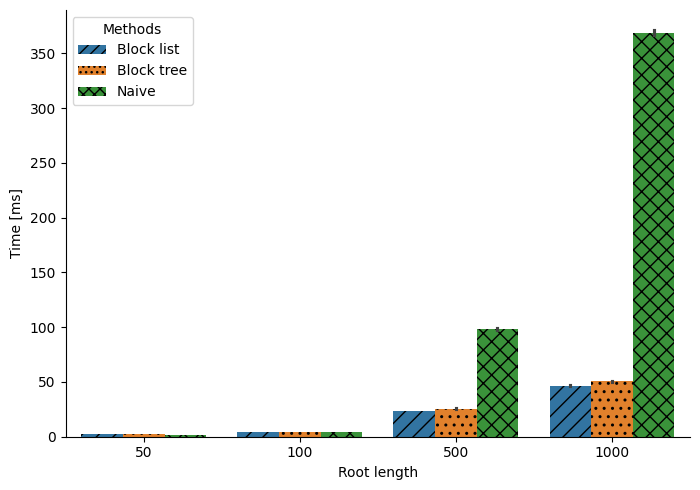

In [16]:
ax = sns.barplot(data=df_scores, x="Root length", y="Time [ms]", hue="Method")
ax.figure.set_size_inches(7.1, 5)
sns.despine()
hatches = ['//', '//', '//','//', 
           '..', '..', '..', '..', 
           'xx', 'xx', 'xx', 'xx',
            '///','...', 'xxx']
# Loop over the bars

for i,thisbar in enumerate(ax.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[i])

handles, old_labels = ax.get_legend_handles_labels()
new_labels = ['Block list', 'Block tree', 'Naive']  # Your custom labels here
plt.legend(handles, new_labels, title='Methods')

plt.tight_layout()
plt.savefig("assets/orthomam_benchmark_root_length.svg",bbox_inches="tight", dpi=300)
plt.savefig("assets/orthomam_benchmark_root_length.png",bbox_inches="tight", dpi=300)



In [17]:
times_df.iloc[:,2:].idxmin(axis=1).value_counts()


blocklist    1359
naive         556
blocktree     249
Name: count, dtype: int64

In [49]:
df_scores.groupby(["Root length", "Method"]).describe()["Time [ms]"]

count        mean        std         min         25%  \
Root length Method                                                            
50          blocklist  541.0    2.228572   0.665992    1.674651    1.871170   
            blocktree  541.0    2.519296   0.772421    1.768397    2.084628   
            naive      541.0    1.660661   0.487821    1.155410    1.385488   
100         blocklist  541.0    4.145797   0.975740    3.229194    3.536070   
            blocktree  541.0    4.531503   1.071410    3.529794    3.895343   
            naive      541.0    4.638135   0.835775    3.688292    4.088311   
500         blocklist  541.0   23.374047   3.152011   17.609951   21.794921   
            blocktree  541.0   25.572835   4.406949   18.772189   23.397701   
            naive      541.0   98.399057  12.746679   74.917959   92.138561   
1000        blocklist  541.0   46.735510   5.803826   38.524332   43.760360   
            blocktree  541.0   50.702737   5.350754   40.592086   47.456958   
            naive      541.0  368.931296  26.236868  304.937982  350.431156   

                              50%         75%         max  
Root length Method                                         
50          blocklist    1.995135    2.293293    6.572578  
            blocktree    2.241860    2.630192    7.122410  
            naive        1.496726    1.712366    4.338214  
100         blocklist    3.783454    4.504089   12.766997  
            blocktree    4.173281    4.822751   13.936213  
            naive        4.366040    4.937101   11.380965  
500         blocklist   22.672740   24.531953   55.486400  
            blocktree   24.719839   26.810529   60.624067  
            naive       96.922893  102.518443  209.954599  
1000        blocklist   45.627959   47.758978  114.798123  
            blocktree   49.820280   52.485843  105.585780  
            naive      366.128707  383.016909  471.668620

In [11]:
times_df_50.describe()

,index,hybrid,blocktree,blocklist,naive,Root length
count,541.000000,541.0,541.000000,541.000000,541.000000,541.0
mean,270.000000,1000.0,0.002519,0.002229,0.001661,50.0
std,156.317519,0.0,0.000772,0.000666,0.000488,0.0
min,0.000000,1000.0,0.001768,0.001675,0.001155,50.0
25%,135.000000,1000.0,0.002085,0.001871,0.001385,50.0
50%,270.000000,1000.0,0.002242,0.001995,0.001497,50.0
75%,405.000000,1000.0,0.002630,0.002293,0.001712,50.0
max,540.000000,1000.0,0.007122,0.006573,0.004338,50.0


In [27]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scipy.stats as stats

In [31]:
df_scores

,Root length,Method,Time,Time [ms]
0,50,blocklist,0.002271,2.270837
1,50,blocktree,0.002418,2.417862
2,50,naive,0.001896,1.895847
3,50,blocklist,0.004532,4.531883
4,50,blocktree,0.006004,6.004251
...,...,...,...,...
6487,1000,blocktree,0.050691,50.690771
6488,1000,naive,0.356871,356.871125
6489,1000,blocklist,0.044699,44.699164
6490,1000,blocktree,0.047462,47.462481


In [36]:
df_scores.columns.tolist()

['Root length', 'Method', 'Time', 'Time [ms]']

In [47]:
model = ols('Time ~ C(Method) * C(Q("Root length"))', data=df_scores).fit()
anova_table = anova_lm(model, typ=2)
print(anova_table)
anova_table

                                  sum_sq      df              F  PR(>F)
C(Method)                      13.980676     2.0   88616.243371     0.0
C(Q("Root length"))            25.087678     3.0  106011.844211     0.0
C(Method):C(Q("Root length"))  24.977469     6.0   52773.068435     0.0
Residual                        0.511163  6480.0            NaN     NaN


,sum_sq,df,F,PR(>F)
C(Method),13.980676,2.0,88616.243371,0.0
"C(Q(""Root length""))",25.087678,3.0,106011.844211,0.0
"C(Method):C(Q(""Root length""))",24.977469,6.0,52773.068435,0.0
Residual,0.511163,6480.0,NaN,NaN


In [44]:
tukey_algorithm = pairwise_tukeyhsd(endog=df_scores['Time'],
                                    groups=df_scores['Method'],
                                    alpha=0.05)
print(tukey_algorithm)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj   lower  upper  reject
---------------------------------------------------------
blocklist blocktree   0.0017 0.7995 -0.0046  0.008  False
blocklist     naive   0.0993    0.0   0.093 0.1056   True
blocktree     naive   0.0976    0.0  0.0913 0.1039   True
---------------------------------------------------------


In [45]:

# For scenario main effect
tukey_scenario = pairwise_tukeyhsd(endog=df_scores['Time'],
                                   groups=df_scores['Root length'],
                                   alpha=0.05)
print(tukey_scenario)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    50    100   0.0023 0.8349 -0.0047 0.0093  False
    50    500    0.047    0.0  0.0399  0.054   True
    50   1000   0.1533    0.0  0.1463 0.1604   True
   100    500   0.0447    0.0  0.0376 0.0517   True
   100   1000    0.151    0.0   0.144 0.1581   True
   500   1000   0.1063    0.0  0.0993 0.1134   True
---------------------------------------------------
